In [1]:
# Global Suicide Rate Analysis
%matplotlib inline

# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
# Read master suicide rates data into dataframe
master_data_df = pd.read_csv("./source_data/master.csv")

# print(len(master_data_df))

# master_data_df.head()


In [3]:
# Cleaningup raw data
master_data_df.columns

master_data_df = master_data_df.drop_duplicates()

master_data_df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'}, inplace=True)

# print(len(master_data_df))
# print(master_data_df.count())


In [4]:
# Filtering 10 years data (2006-2015) 
ten_yr_df = master_data_df.loc[(master_data_df["year"]>2005) & (master_data_df["year"]<2016)]

ten_yr_df.to_csv("./source_data/ten_yr_data.csv")
# print(len(ten_yr_df))
# print(ten_yr_df.count())


In [5]:
# Determining Top 10 countries with higher suicide numbers (10 year)
country_grp = ten_yr_df.groupby(["country"])

country_grp_df = pd.DataFrame({"total_suicides_no": country_grp["suicides_no"].sum()})

country_grp_df = country_grp_df.reset_index()

country_grp_df = country_grp_df.sort_values(["total_suicides_no"], ascending=False)

country_grp_df.to_csv("./source_data/top_country_grp_data.csv")

# print(len(country_grp_df))

# country_grp_df.head(10)


In [6]:
# Yearly population by country - combining population of both male and female, all ages (all countries, 10 years)
country_yr_grp = ten_yr_df.groupby(["country","year"])

country_yr_grp_df = pd.DataFrame({"country_yearly_population": country_yr_grp["population"].sum()
                                 ,"country_yearly_suicides": country_yr_grp["suicides_no"].sum()
                                 })

# country_yr_grp_df.head(20)


In [7]:
# Filter 10 year data for top 10 countries
top_country_ten_yr_df = pd.merge(ten_yr_df,country_grp_df.iloc[0:10], how='inner', on='country')

# Merging coutry_yearly_population for top 10 countries
top_country_ten_yr_df = pd.merge(top_country_ten_yr_df, country_yr_grp_df, how='inner', on=['country','year']) 

top_country_ten_yr_df.to_csv("./source_data/top_country_ten_yr_data.csv")

# print(len(top_country_ten_yr_df), top_country_ten_yr_df['country'].nunique())
# print(top_country_ten_yr_df.count())

# top_country_ten_yr_df.head(10)


In [8]:
# Calculate suicide totals grouped by age buckets and gender combined for 10 countries 10 years
age_grp = top_country_ten_yr_df.groupby (["age", "sex"])

age_grp_df = pd.DataFrame({"total_suicide_age": age_grp["suicides_no"].sum()})

age_grp_df = age_grp_df.reset_index()

# age_grp_df.head(30)


In [9]:
# Sort by age groups 
age_list = age_grp_df["age"]

age_to_sort = []

age_to_sort = [int(str(age)[0:2].replace("-","")) for age in age_list] 

age_grp_df["age_to_sort"] = age_to_sort

age_grp_df = age_grp_df.sort_values("age_to_sort", ascending=True)

# age_grp_df.head(50)


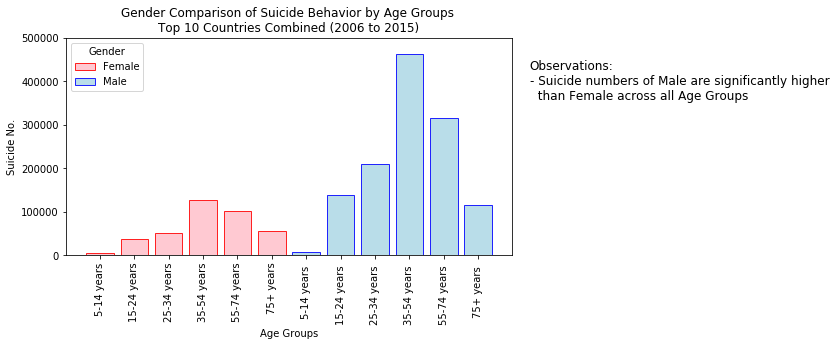

In [10]:
# Plot Gender Comparison of Suicide behavior by Age Groups
x = age_grp_df.loc[age_grp_df["sex"] == "female"]
y = age_grp_df.loc[age_grp_df["sex"] == "male"]

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

ax.set_ylim(top=500000)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

bar_width = 0.5
female = ax.bar(x["age"], height=x["total_suicide_age"], color='pink', edgecolor='red', alpha=0.85, label='Female')
male = ax.bar(y["age"]+' ', height=y["total_suicide_age"], color='lightblue', edgecolor='blue', alpha=0.85, label='Male', align='center')

lgnd = ax.legend(handles=[female,male],title="Gender", loc='upper left')
ax.set_xlabel("Age Groups")
ax.set_ylabel("Suicide No.")
plt.title("Gender Comparison of Suicide Behavior by Age Groups \nTop 10 Countries Combined (2006 to 2015)")

# Incorporate a observations
obs = "Observations:\n- Suicide numbers of Male are significantly higher \n  than Female across all Age Groups"
        
ax.text(12.5,400000,s=obs,horizontalalignment='left',verticalalignment='center',clip_on=False, fontsize=12)

# Save Figure
plt.savefig("./Images/genderComparison.png",bbox_inches='tight',dpi=100)
plt.show()


In [11]:
# Calculate yearly population, gdp & suicide numbers
yrly_grp = top_country_ten_yr_df.groupby(["country","year"])

yrly_grp_df = pd.DataFrame({"gdp_yrly": yrly_grp["gdp_per_capita ($)"].mean()
                                  ,"pop_yrly": (yrly_grp["country_yearly_population"].mean()/100000).astype(int)
                                  ,"suicides_yrly": yrly_grp["suicides/100k pop"].sum()})

yrly_grp_df = yrly_grp_df.reset_index()

# yrly_grp_df.head(20)


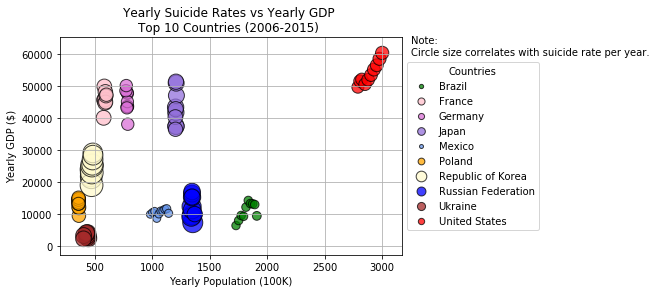

In [12]:
# Build the scatter plots for each country
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.subplots_adjust(right=0.6)

colors = ["green","pink","orchid","mediumpurple","cornflowerblue","orange","lemonchiffon","blue","brown","red"]
x = yrly_grp_df["country"].unique()
hands = []

for index, h in enumerate(x):
    country_yrly_grp_df = yrly_grp_df.loc[yrly_grp_df["country"]==h]
    hands.append(ax.scatter(country_yrly_grp_df["pop_yrly"], country_yrly_grp_df["gdp_yrly"], s=country_yrly_grp_df["suicides_yrly"]\
            , marker='o', c=colors[index], edgecolors='black', alpha=0.75, linewidths=1, label=h))

# Add graph properties
ax.legend(handles=hands, markerscale=0.5,title="Countries", loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Yearly Population (100K)")
ax.set_ylabel("Yearly GDP ($)")
ax.set_title("Yearly Suicide Rates vs Yearly GDP \nTop 10 Countries (2006-2015) ")
ax.grid()

# Incorporate a text label regarding circle size
ax.text(3250,62500,s="Note:\nCircle size correlates with suicide rate per year."\
         ,horizontalalignment='left',verticalalignment='center'\
        ,clip_on=False, fontsize=10)


# Save Figure
plt.savefig("./Images/SuicideScatter.png",bbox_inches='tight',dpi=100)

plt.show()


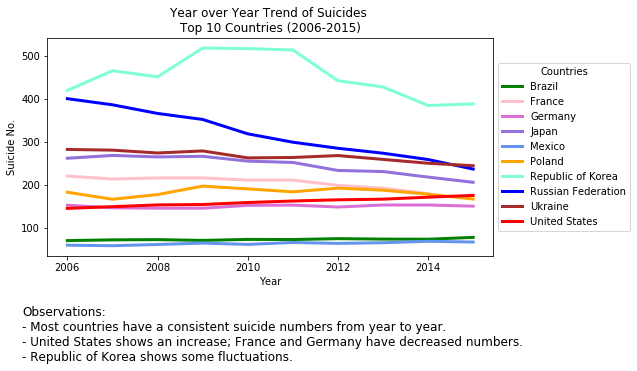

In [13]:
# Build the year over year trend plot of suicides for each country
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

colors1 = ["green","pink","orchid","mediumpurple","cornflowerblue","orange","aquamarine","blue","brown","red"]

x = yrly_grp_df["country"].unique()
hands = []

for index, h in enumerate(x):
    country_yrly_grp_df = yrly_grp_df.loc[yrly_grp_df["country"]==h]
    ax.plot(country_yrly_grp_df["year"], country_yrly_grp_df["suicides_yrly"], c=colors1[index], label=h, linewidth=3)

# Add graph properties
ax.legend(title="Countries", loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Year")
ax.set_ylabel("Suicide No.")
ax.set_title("Year over Year Trend of Suicides \nTop 10 Countries (2006-2015)")


# Incorporate a observations
obs = "Observations:\n- Most countries have a consistent suicide numbers from year to year.\n- United States shows an increase; France and Germany have decreased numbers.\n- Republic of Korea shows some fluctuations."
        
ax.text(2005,-150,s=obs,horizontalalignment='left',verticalalignment='center',clip_on=False, fontsize=12)

# Save Figure
plt.savefig("./Images/SuicideYearTrend.png",bbox_inches='tight',dpi=100)

plt.show()